In [1]:
#import relevant libraries
import sys
import os
import glob
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean

import dabest_jck
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


In [2]:
#initial file processing
computer1 = "C:\\Users\\User"
computer2 = "C:\\Users\\lnico"
filedir = "\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
openPath = computer1 + filedir
files = os.listdir(openPath)

#identifying genotypes
responder = "ACR"
respondercsv = responder + ".csv"
wt = "w1118"

In [3]:
lst=[]


for file_no in os.listdir(openPath): 
    if respondercsv in file_no and "w1118" not in file_no :   #wt > acr files
        f = os.path.join(openPath, file_no)
        dfe=pd.read_csv(f)
        exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
        driver = file_no.split(" ")[0]
        lst.append(driver)

In [4]:
def timeabove(dfexpt, dfwt):

    #time above mean line
    heightwt = NLMATH.maxheight(dfwt, "wt")
    avgmaxheight_wt = heightwt['Max height wt'].mean() 

    ce = NLMATH.timespentabovemeanline(dfexpt, avgmaxheight_wt, "Expt")
    ce2 = NLMATH.timespentabovemeanline(dfwt, avgmaxheight_wt, "WT")

    timehang = pd.DataFrame()
    timehang = pd.concat([ce, ce2], axis = 0)
    timehang['genre'] = timehang['ExperimentState'] + " " + timehang['Type']
    
    
    timeabovemeanline = dabest.load(data=timehang, x=["ExperimentState","Type"], y= "Time", delta2 = True, 
                               experiment="Type",experiment_label = ["WT", "Expt"], x1_level = ["Dark","Full"], 
                               paired = "sequential", id_col = "index")
    lst= []
    lst.append(timeabovemeanline.mean_diff.delta_delta.difference)
    
    return lst

# def ospeed(dfexpt, dfwt): #overall speed

#     df_se = NLMATH.velodabest(dfexpt, "Expt", "Velocity.*")
#     df_sw = NLMATH.velodabest(dfwt, "WT", "Velocity.*")

#     fgt6=pd.DataFrame()
#     fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
#     fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

#     overallspeed = dabest.load(data=fgt6, x=["ExperimentState","Type"], y="Velocity", delta2 = True, experiment="Type", experiment_label = ["WT", "Expt"], x1_level = ["Dark","Full"], paired = "baseline", id_col = "index")
#     lst= []
#     lst.append(overallspeed.mean_diff.delta_delta.difference)
#     return lst

def falls(dfe_dark, dfe_full, dfw_dark, dfw_full):
    
    filtered = (dfe_dark.filter(regex="Fall.*").sum(axis=0))/1
    filtered2 = (dfe_full.filter(regex="Fall.*").sum(axis=0))/1
    filtered3 = (dfw_dark.filter(regex="Fall.*").sum(axis=0))/1
    filtered4 = (dfw_full.filter(regex="Fall.*").sum(axis=0))/1

    awt=pd.DataFrame()
    awt['Falls']=filtered
    awt['ExperimentState'] = "Dark"

    awt2=pd.DataFrame()
    awt2['Falls']=filtered2
    awt2['ExperimentState'] = "Full"


    awt2b = pd.concat([awt, awt2]).reset_index()
    awt2b["Type"] = "Expt"

    awt3=pd.DataFrame()
    awt3['Falls']=filtered3
    awt3['ExperimentState'] = "Dark"

    awt4=pd.DataFrame()
    awt4['Falls']=filtered4
    awt4['ExperimentState'] = "Full"
    awt4b = pd.concat([awt3, awt4]).reset_index()
    awt4b["Type"] = "WT"
    

    awt5=pd.DataFrame()
    awt5 = pd.concat([awt2b, awt4b])
    
    return awt5

def manyfall (dfexpt, dfwt):
    
    dfe_dark = dfexpt[(dfexpt['ExperimentState']== 'Dark')] 
    dfe_full = dfexpt[(dfexpt['ExperimentState']== 'Full')] 
    dfw_dark = dfwt[(dfwt['ExperimentState']== 'Dark')] 
    dfw_full = dfwt[(dfwt['ExperimentState']== 'Full')] 
    awt5 = falls(dfe_dark, dfe_full, dfw_dark, dfw_full)

    awt5['genre'] = awt5['ExperimentState'] + " " + awt5['Type']
    awt5['value'] = 0
    awt5.loc[(awt5['Falls'] >0), ['value']] = 1

  
    deltaplots = dabest.load(data=awt5, x=["ExperimentState","Type"], y="Falls", delta2 = True, experiment="Type", experiment_label = ["WT", "Expt"], x1_level = ["Dark","Full"], paired = "sequential", id_col = "index")
    
    lst= []
    lst.append(deltaplots.mean_diff.delta_delta.difference)
    return lst


# run if new data

In [5]:
def pddelta(df_sp, genotype, metric):    
    
    df9 = pd.DataFrame()
    dfsp_db = df_sp[(df_sp['ExperimentState'] != "Recovery") ]
    dfsp_db2 = dabest_jck.load(data = dfsp_db, x = ['ExperimentState', 'ExperimentState'], y = metric, delta2 = True, experiment = "Type", x1_level = ["Dark", "Full"], experiment_label = ["WT","Expt"] ) #if delta2 = dabest; deltaG = dabest_jck
    df9[genotype] = dfsp_db2.delta_g.delta_delta.bootstraps_delta_delta.tolist() #if delta2: dfsp_db2 .mean_diff.delta_delta.bootstraps_delta_delta.tolist() if deltaG = dfsp_db2 .delta_g.delta_delta.bootstraps_delta_delta.tolist()
    
    roundmean = round(dfsp_db2.delta_g.delta_delta.difference,3)
    dfdiff = pd.DataFrame({"delta_g": roundmean, "MBON": genotype}, index = [genotype])
    
    
    return df9, dfdiff

def ospeed(dfwt, dfexpt):
    
    df_se = NLMATH.velodabest(dfexpt, "Expt", "Velocity")
    df_sw = NLMATH.velodabest(dfwt, "WT", "Velocity")
    
    fgt6=pd.DataFrame()
    fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
    fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

    return fgt6

def timetype(dfwt, dfexpt):
    
    heightwt = NLMATH.maxheight(dfwt, "wt")
    avgmaxheight_wt = heightwt['Max height wt'].mean() 

    ce = NLMATH.timespentabovemeanline(dfexpt, avgmaxheight_wt, "Expt")
    ce2 = NLMATH.timespentabovemeanline(dfwt, avgmaxheight_wt, "WT")

    timehang = pd.DataFrame()
    timehang = pd.concat([ce, ce2], axis = 0)
    timehang['genre'] = timehang['ExperimentState'] + " " + timehang['Type']
    
    return timehang

def separation(dfexpt, dfwt, phrase):
        
    dfe_dark = dfexpt[(dfexpt['ExperimentState']== 'Dark')] 
    dfe_full = dfexpt[(dfexpt['ExperimentState']== 'Full')] 
    dfw_dark = dfwt[(dfwt['ExperimentState']== 'Dark')] 
    dfw_full = dfwt[(dfwt['ExperimentState']== 'Full')] 
    
    filterword = phrase + ".*"
    
    expts = [dfe_dark, dfe_full, dfw_dark, dfw_full]
    results = []
    for e in expts:
        filtereddf = e.filter(regex=filterword)
    
        match phrase:
            case "Y":
                result = getattr(filtereddf, "mean")(axis=0)
            case "Fall":
                result = getattr(filtereddf, "sum")(axis=0)/1
                
        results.append(result)
        
    awt=pd.DataFrame()
    awt[phrase]= results[0]
    awt['ExperimentState'] = "Dark"

    awt2=pd.DataFrame()
    awt2[phrase]=results[1]
    awt2['ExperimentState'] = "Full"

    awt2b = pd.concat([awt, awt2]).reset_index()
    awt2b["Type"] = "Expt"


    awt3=pd.DataFrame()
    awt3[phrase]=results[2]
    awt3['ExperimentState'] = "Dark"

    awt4=pd.DataFrame()
    awt4[phrase]=results[3]
    awt4['ExperimentState'] = "Full"
    awt4b = pd.concat([awt3, awt4]).reset_index()
    awt4b["Type"] = "WT"
    

    awt5=pd.DataFrame()
    awt5 = pd.concat([awt2b, awt4b])
    
    return awt5

def fallingocc(dfexpt, dfwt):
    
    awt5 = separation(dfexpt, dfwt, "Fall")
    awt5['genre'] = awt5['ExperimentState'] + " " + awt5['Type']
    awt5['value'] = 0
    awt5.loc[(awt5['Fall'] >0), ['value']] = 1

    return awt5

def totalheight(dfexpt, dfwt):
    
    awt5 = separation(dfexpt, dfwt, "Y")
    awt5['genre'] = awt5['ExperimentState'] + " " + awt5['Type']

    return awt5

def countval(data, value):  #value = pause events
    count = 0
    timelst =[]
    for key, group in itertools.groupby(data, lambda x: x == value ):
        groupAsList = list(group)
        if( key == True ):
            count += 1
            timed = 0.2*len(groupAsList)
            timelst.append(timed)

        
    return (count, timelst)

def behavior (dfp):
   
    pc = dfp.filter(regex="Pausecount_.*")
    countpause = []
    countbout = []
    pcpause = pd.DataFrame()
    pcbout = pd.DataFrame()

    for n in pc:
        pc9 = pd.DataFrame()
        counter1, pausetime = countval(pc[n], 1) #pause = 1
        counter0, bouttime = countval(pc[n], 0) #bout = 0
        
        countpause.append(counter1)
        countbout.append(counter0)
        
        pcpause = pd.concat([pcpause, pd.Series(pausetime, dtype='float64')], ignore_index = True, axis = 1)
        pcbout = pd.concat([pcbout, pd.Series(bouttime, dtype='float64')], ignore_index = True, axis = 1)

    return countpause, countbout, pcpause, pcbout

def boutanalysis(df_dark, phase) : 
    
    countpause, countbout, pausedark, boutdark = behavior(df_dark)
    
    #avg paus time per fly (Mean Activity time spent per fly)
    meanpdark = pausedark.mean(axis = 0)
    meanbdark = boutdark.mean(axis = 0)
    meandarkevent = pd.DataFrame({"Pauses_" + phase: meanpdark, "Bouts_" + phase: meanbdark})
    
    #time per activity (raw_marker_size=0.5 ,swarm_label= "Time spent per activity")
    pausedarkdf = pausedark.melt().drop(['variable'], axis =1).dropna(axis = "index")
    boutdarkdf = boutdark.melt().drop(['variable'], axis =1).dropna(axis = "index")
    timedarkevent = pd.DataFrame({"Pauses_" + phase: pausedarkdf['value'], "Bouts_" + phase: boutdarkdf['value']})
    
    #occurences
    countevent = pd.DataFrame({"Pauses_" + phase: countpause, "Bouts_" + phase: countbout})
    
    return countevent, meandarkevent, timedarkevent

def pausecomp(dft, genre): #genre is either w1118, or driver line
    
    df_dark = dft[(dft['ExperimentState'] == 'Assimilation time - Dark') | (dft['ExperimentState']== 'Dark')] 
    df_light = dft[(dft['ExperimentState'] == 'Assimilation time - Full') | (dft['ExperimentState']== 'Full')] 
    df_rec = dft[(dft['ExperimentState']== 'Recovery')]
    
    countdark, meandarkevent, timedarkevent  = boutanalysis(df_dark, "Dark")
    countlight, meanlightevent, timelightevent  = boutanalysis(df_light, "Full")
    countrec, meanrecevent, timerecevent  = boutanalysis(df_rec, "Recovery")
    
    totalmeanevent = pd.concat([meandarkevent, meanlightevent, meanrecevent], axis =1)
    totalmeanevent = totalmeanevent.add_prefix(genre + "_")
    
    # totaltimeevent = pd.concat([timedarkevent, timelightevent, timerecevent], axis =1)
    # totaltimeevent = totaltimeevent.add_prefix(genre + "_")
    
    totalnumberevent = pd.concat([countdark, countlight, countrec], axis =1)
    totalnumberevent = totalnumberevent.add_prefix(genre + "_")
    
    return totalmeanevent, totalnumberevent

def pausenumber (df1, genotype, genre):# genre = either pause or bout
            
    df = pd.DataFrame()
    df9 = pd.DataFrame()
    
    for n in df1.columns:
        if n.split("_")[0] == "w1118":
            type1 = "WT"
        if n.split("_")[0] == genotype:
            type1 = "Expt"
        tempnumber = pd.DataFrame()
        tempnumber["value"] = df1[n]
        tempnumber["Type"] = type1 #genre
        tempnumber["behavior"] = n.split("_")[1] #behavior
        tempnumber["ExperimentState"] = n.split("_")[2] #state
        df = pd.concat([df, tempnumber], axis = 0)
            
    deltadf =  df[df["behavior"]== genre]
    deltadf = deltadf.rename(columns = {"value": genre})
    
    df9, dfdiff = pddelta(deltadf, genotype, genre)
    
    # deltadf_db = dabest.load(data = deltadf, x = ['ExperimentState', 'ExperimentState'], y = genre, delta2 = True, experiment = "Type", x1_level = ["Dark", "Full"], experiment_label = [wt,driver]) #if deltadelta, use dabest; if deltaG, use dabest_jck
    # df9[genotype] = deltadf_db.mean_diff.delta_delta.bootstraps_delta_delta.tolist()
    # roundmean = round(deltadf_db.mean_diff.delta_delta.difference,3)
    # dfdiff = pd.DataFrame({"delta_delta": roundmean, "MBON": genotype}, index = [genotype])
    
    return df9, dfdiff

def boutspeed(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    #velper = pd.DataFrame()
    for v2 in range(3,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+1]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " BSpeed_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==0), [k + " BSpeed_" + n]] = velp[k + " Velocity_" + n]

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def bspeed(dfexpt, dfwt):
    df_se = NLMATH.velodabest(dfexpt, "Expt", "BSpeed")
    df_sw = NLMATH.velodabest(dfwt, "WT", "BSpeed")
    
    fgt6=pd.DataFrame()
    fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
    fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

    return fgt6


def disptravel (dft, light, genre):    


    totaltravel = pd.DataFrame()

    totaldisptravelled = pd.DataFrame()
    dispdf = (dft.filter(regex="Velocity.*"))*0.2
    totaldisptravelled = dispdf.sum(axis= 0)

    lstdisp = totaldisptravelled.index.tolist()
    lstdisp = [s.replace("Velocity", "disp") for s in lstdisp]

    totaldisptravelled.index = lstdisp

    
    totaltravel['displacement'] = totaldisptravelled
    totaltravel["ExperimentState"] = light
    totaltravel["Type"] = genre
    totaltravel['genre'] = light + " " + genre
    

    return totaltravel.reset_index()

def totaldisp(dft, genre):
    
    df_dark = dft[(dft['ExperimentState'] == 'Assimilation time - Dark') | (dft['ExperimentState']== 'Dark')] 
    df_light = dft[(dft['ExperimentState'] == 'Assimilation time - Full') | (dft['ExperimentState']== 'Full')] 
    df_rec = dft[(dft['ExperimentState']== 'Recovery')]
    
    dispdark  = disptravel(df_dark, "Dark", genre)
    displight  = disptravel(df_light, "Full", genre)
    disprec = disptravel(df_rec, "Recovery", genre)
    
    totaldisp = pd.concat([dispdark, displight, disprec], axis = 0).reset_index(drop=True)
    
    return totaldisp   

def boutheight(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    velper = pd.DataFrame()
    for v2 in range(1,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+3]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " Height_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==0), [k + " Height_" + n]] = velp[k + " Y_" + n]

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def pauseheight(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    velper = pd.DataFrame()
    for v2 in range(1,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+3]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " Height_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==1), [k + " Height_" + n]] = velp[k + " Y_" + n]

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def bheight(dfexpt, dfwt):
    df_se = NLMATH.velodabest(dfexpt, "Expt", "Height")
    df_sw = NLMATH.velodabest(dfwt, "WT", "Height")
    
    fgt6=pd.DataFrame()
    fgt6 = pd.concat([df_se, df_sw]).reset_index(drop=False)
    fgt6['genre'] = fgt6['ExperimentState'] + " " + fgt6['Type']

    return fgt6

def timeperiod(df, number):
    df1= pd.DataFrame()
    pos = int(number*5) #5fps
    df_dark = df[(df['ExperimentState'] == 'Assimilation time - Dark') | (df['ExperimentState']== 'Dark')].iloc[0:pos,:] 
    df_light = df[(df['ExperimentState'] == 'Assimilation time - Full') | (df['ExperimentState']== 'Full')].iloc[0:pos,:] 
    df_rec = df[(df['ExperimentState']== 'Recovery')].iloc[0:pos,:] 
    
    df1 =pd.concat([df_dark, df_light, df_rec], axis = 0)

    return df1.reset_index(drop=True)

In [6]:
lst = ['MB011B']

In [32]:
dftest = dfexpt[dfexpt['ExperimentState'] == "Dark"]
distpersec(dftest)

,Seconds,ExperimentState,Dist_4,Dist_5,Dist_7,Dist_8,Dist_14,Dist_15,Dist_16,Dist_17,...,Dist_56,Dist_57,Dist_58,Dist_59,Dist_60,Dist_61,Dist_62,Dist_63,Dist_64,Dist_65
0,3.0,Dark,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,Dark,2.171459,2.516067,9.859190,6.297810,13.434289,7.846696,3.392587,8.241959,...,8.504291,0.834429,8.700337,16.843077,6.907517,13.104540,14.048145,11.443181,15.110626,5.283552
2,5.0,Dark,3.528571,3.376890,2.760728,1.085647,7.701462,1.928647,4.797761,8.150308,...,12.352338,9.464426,8.194531,5.417323,7.380250,13.836626,10.696810,8.157422,11.533223,1.220309
3,6.0,Dark,0.241982,7.853742,7.843498,7.064219,2.853890,2.881140,8.833171,3.750433,...,1.460403,0.052006,9.887389,1.193201,7.131250,14.645654,0.878740,7.134191,1.131733,0.124343
4,7.0,Dark,0.450069,8.329960,4.800459,5.496286,1.704576,9.423748,9.211388,5.107060,...,0.345907,0.079802,7.783308,0.580394,6.340897,8.070722,2.021859,8.221380,1.502043,0.102952
5,8.0,Dark,0.018355,9.032139,4.808881,7.568211,2.961450,6.850664,7.327611,7.443233,...,0.016203,0.118319,5.331701,0.271984,7.006282,2.897264,0.293113,7.035848,0.446993,0.102074
6,9.0,Dark,0.161161,9.228973,0.017222,7.668201,3.071857,5.100034,2.657913,7.596722,...,0.041086,0.131330,8.550643,1.308717,3.322152,1.607277,1.881412,3.461770,1.685548,0.122506
7,10.0,Dark,0.178806,8.502978,0.037321,5.467224,2.520390,1.165916,2.632959,5.444403,...,0.277137,0.047472,2.908611,0.842243,6.882571,1.798933,1.498284,1.439192,0.048102,0.328997
8,11.0,Dark,0.189720,7.863670,4.054384,6.306961,0.617865,0.569472,1.521677,7.335061,...,0.185230,0.284722,1.119911,1.384957,3.595900,1.398927,0.048097,0.034912,0.239630,0.153836
9,12.0,Dark,0.168116,5.310067,8.586961,0.953927,6.347987,0.458709,2.131779,5.224801,...,0.011258,0.220202,1.717643,0.334272,4.418847,2.073291,0.017365,0.016850,0.051976,0.182006


In [31]:
#distance per sec

def distpersec (dfexpt):
    dfnewt = dfexpt.iloc[::5,:].reset_index(drop=True)
    dfnewt.drop(dfnewt.filter(regex='Fall_.*|Velocity_.*|Pausecount_.*').columns, axis=1, inplace=True)

    dfnewt3 = dfnewt.iloc[:,2:].copy()
    distsec = pd.DataFrame()
    for v2 in range(0,len(dfnewt3.columns),2):
        dfnewt4= pd.DataFrame()
        #assining name
        naming = (dfnewt3.iloc[:,v2]).name
        arraynum = naming.split("_")[1]
        
        dfnewt4 = pd.concat([dfnewt3.iloc[:,v2], dfnewt3.iloc[:,v2+1]], axis = 1)
        distsec["Dist_" + str(arraynum)] = np.linalg.norm(dfnewt4.diff(axis=0), axis=1)
    distsec = pd.concat([dfnewt.iloc[:,0:2], distsec], axis = 1).reset_index(drop=True)
    
    return distsec
    

In [35]:
dftest = dfexpt[dfexpt['ExperimentState'] == "Dark"]
disppersec(dftest)

,MB011B Velocity_4,MB011B Velocity_5,MB011B Velocity_7,MB011B Velocity_8,MB011B Velocity_14,MB011B Velocity_15,MB011B Velocity_16,MB011B Velocity_17,MB011B Velocity_19,MB011B Velocity_21,...,MB011B Velocity_56,MB011B Velocity_57,MB011B Velocity_58,MB011B Velocity_59,MB011B Velocity_60,MB011B Velocity_61,MB011B Velocity_62,MB011B Velocity_63,MB011B Velocity_64,MB011B Velocity_65
3,2.116377,2.134316,9.911386,5.992884,10.318665,6.633158,3.155561,6.887154,14.371608,6.882691,...,6.116140,0.713686,7.063706,13.824507,5.482988,10.784226,11.817061,9.653328,12.149918,5.367539
4,3.360892,1.740215,2.002588,5.391257,6.924313,2.211559,3.505032,6.522930,4.053029,2.771084,...,12.310078,8.582990,6.799886,5.809176,6.143214,12.043480,9.779730,7.048341,9.565518,1.316341
5,0.341185,6.490050,6.806515,5.334083,3.254540,1.555090,7.764509,3.303672,2.435897,2.773399,...,2.189152,0.201550,8.152819,1.242347,5.700308,12.503624,1.449980,5.674988,1.345577,0.135850
6,0.350169,6.746836,4.869994,4.110775,1.733919,6.903312,7.088174,3.770295,4.562223,2.098757,...,0.604884,0.204585,5.769375,0.765638,5.025074,8.541903,1.843952,7.005987,1.725908,0.113971
7,0.087203,7.474878,4.385081,6.139974,2.955343,6.292919,6.769711,6.042142,4.792502,3.812447,...,0.104015,0.106683,3.920483,0.333255,5.728169,2.299007,0.619539,5.711574,1.170349,0.164923
8,0.793093,7.632620,0.078845,6.167260,4.242848,5.196761,1.992968,5.756531,3.187348,2.186359,...,0.089727,0.171872,7.122772,1.250498,2.864350,1.556310,0.850111,3.389922,1.213915,0.190303
9,0.477276,6.773240,0.064328,4.130423,3.823699,1.510346,2.418448,4.448987,5.419551,1.923655,...,0.084766,0.160482,3.944604,1.551170,5.858448,1.290788,1.884032,1.365620,0.098330,0.562159
10,0.213684,6.186196,2.367623,6.118123,0.686569,0.831841,1.663706,5.615534,4.595955,1.496528,...,0.231005,0.167152,1.399988,1.427667,2.365386,1.621488,0.120758,0.074668,0.290532,0.215988
11,0.329985,5.310883,6.560907,1.118509,4.880660,0.856004,2.186987,5.165400,2.210926,4.383227,...,0.063588,0.233158,1.863141,0.389457,4.051459,2.472500,0.053693,0.092889,0.039839,0.378054
12,0.228066,0.571578,4.789759,0.404436,4.432881,1.845253,0.124012,1.541576,1.729894,1.446181,...,0.096542,0.400006,0.964897,0.220052,2.004887,1.172193,0.053523,0.130709,0.078482,0.113216


In [36]:
dftest

,Seconds,ExperimentState,MB011B X_4,MB011B Y_4,MB011B Fall_4,MB011B Velocity_4,MB011B Pausecount_4,MB011B X_5,MB011B Y_5,MB011B Fall_5,...,MB011B X_64,MB011B Y_64,MB011B Fall_64,MB011B Velocity_64,MB011B Pausecount_64,MB011B X_65,MB011B Y_65,MB011B Fall_65,MB011B Velocity_65,MB011B Pausecount_65
15,3.0,Dark,4.75258,27.53520,0.0,1.464561,1.0,5.34758,23.06234,0.0,...,5.68610,58.19114,0.0,11.515106,0.0,4.04264,62.16574,0.0,12.901930,0.0
16,3.2,Dark,4.38774,29.13694,0.0,8.213829,0.0,5.14738,23.91368,0.0,...,5.58628,61.09754,0.0,14.540568,0.0,2.81974,64.92374,0.0,15.084801,0.0
17,3.4,Dark,4.21204,29.53230,0.0,2.163215,1.0,5.15564,23.79496,0.0,...,5.33190,63.84266,0.0,13.784405,0.0,2.17434,67.00232,0.0,10.882366,0.0
18,3.6,Dark,4.19678,29.52516,0.0,0.084239,1.0,5.23530,24.25248,0.0,...,4.31340,66.99560,0.0,16.566814,0.0,2.15586,67.14008,0.0,0.694970,1.0
19,3.8,Dark,4.20070,29.54896,0.0,0.120603,1.0,5.54358,24.85448,0.0,...,3.22490,69.97452,0.0,15.857803,0.0,2.15306,67.10508,0.0,0.175559,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,22.0,Dark,1.52922,55.94764,0.0,4.310191,0.0,4.83378,84.05110,0.0,...,2.89982,85.25818,0.0,0.426197,1.0,2.72496,68.17832,0.0,0.038557,1.0
111,22.2,Dark,1.54882,56.15134,0.0,1.023204,1.0,4.87172,84.02912,0.0,...,2.97808,85.29290,0.0,0.428080,1.0,2.68884,68.26316,0.0,0.461044,1.0
112,22.4,Dark,1.50696,56.06622,0.0,0.474280,1.0,4.83504,84.04718,0.0,...,2.89492,85.26280,0.0,0.442199,1.0,2.70718,68.38622,0.0,0.622096,1.0
113,22.6,Dark,1.27148,56.48874,0.0,2.418543,0.0,4.86850,84.01694,0.0,...,2.95484,85.29766,0.0,0.346613,1.0,2.69850,68.36746,0.0,0.103354,1.0


In [34]:
#displacement per sec
def disppersec(dfexpt):

    distancevelo = 0.2*dfexpt.filter(regex="Velocity_.*")
    dfdist = distancevelo.copy()
    dfdist.iloc[::5,:] =0
    dfdist2 = dfdist.groupby(dfdist.index//5).sum()
    
    return dfdist2


In [7]:
#how much they walk before a pause

def boutdisplacement(dfexpt):
    dfr = dfexpt.iloc[:,2:]
    velp = pd.DataFrame()
    velper = pd.DataFrame()
    for v2 in range(3,len(dfr.columns),5): #change this number if you add more parameters
        velp = pd.concat([velp, dfr.iloc[:,v2], dfr.iloc[:,v2+1]], axis = 1)

    velplst = []
    gentype = []

    for n in velp.columns[::2]:
        velplst.append(n.split("_")[1])
        gentype.append(n.split(" ")[0])

    newspeed = pd.DataFrame()

    for n,k in zip(velplst, gentype):
        newspeed[k + " Perioddisp_" + n] = [np.nan]*len(velp)
        newspeed.loc[(velp[k + " Pausecount_" + n] ==0), [k + " Perioddisp_" + n]] = (velp[k + " Velocity_" + n])*0.2
    newspeed

    newspeed = pd.concat([dfexpt.iloc[:,0:2], newspeed], axis = 1)
    
    return newspeed

def displacementbetweenpauses(df, genre):
    
    df_dispp = pd.DataFrame()    
    phases = ["Dark", "Full"]
    df1 = boutdisplacement(df)
    valuedflist = []
    for phase in phases:
        df47 = df1[(df1['ExperimentState'] == 'Assimilation time - ' + str(phase)) | (df1['ExperimentState']== str(phase))]
        df46 = df47.filter(regex="Perioddisp_.*")
        dftest =pd.DataFrame()
        
        for n in df46.columns:
            df_list = []
            df_00=pd.DataFrame()
            df50 = df46[n]
            x = (df50.shift(1).isnull() & df50.notnull()).cumsum()
            
            for i,g in df50.groupby(x):
                h = g.dropna()
                sumh = np.sum(h)
                df_list.append(sumh)
                          
            vdflist = list(filter(lambda x: x != 0, df_list))
            valuedflist = [mean(vdflist) if len(vdflist) > 0 else []]
            data = {'avgdisplacementbetweenpause': valuedflist, 'ExperimentState': [phase], "Type": genre, 'genre': str(phase)+ " " + str(genre)}
            index = [n]
            df_00=pd.DataFrame(data, index = index)                
            dftest = pd.concat([dftest, df_00], axis =0)
        df_dispp = pd.concat([df_dispp, dftest], axis=0)
        
    df_dispp['avgdisplacementbetweenpause'] = pd.to_numeric(df_dispp['avgdisplacementbetweenpause'])
            
    return df_dispp

In [8]:
#max velocity of each fly after assimilation phase

def maxvelocity(df, genre):
    
    phases = ["Dark", "Full"]
    df_max = pd.DataFrame()
    for phase in phases:
        df2 = df[(df['ExperimentState'] == 'Assimilation time - ' + str(phase)) | (df['ExperimentState']== str(phase))]
        df_dark = df2.filter(regex="Velocity_.*")
        df_maxvelocity = pd.DataFrame()
        df_maxvelocity['maxvelocity'] = df_dark.max(axis = 0)
        df_maxvelocity['ExperimentState'] = phase
        df_maxvelocity['Type'] = genre
        df_maxvelocity['genre'] = str(phase)+ " " + str(genre)
        df_max = pd.concat([df_max, df_maxvelocity], axis=0)
    return df_max


In [9]:
df_speed = pd.DataFrame()
df_time = pd.DataFrame()
df_fall = pd.DataFrame()
df_height = pd.DataFrame()
df_displacement = pd.DataFrame()
df_pause = pd.DataFrame()
df_meanpause = pd.DataFrame()
df_pausepos = pd.DataFrame()
df_bout = pd.DataFrame()
df_meanbout = pd.DataFrame()
df_bspeed = pd.DataFrame()
df_boutpos = pd.DataFrame()
df_pausepos = pd.DataFrame()
df_displacementbetweenpause = pd.DataFrame()
df_maxvelocity = pd.DataFrame()


dfreg_speed = pd.DataFrame()
dfreg_time = pd.DataFrame()
dfreg_fall = pd.DataFrame()
dfreg_height = pd.DataFrame()
dfreg_displacement = pd.DataFrame()
dfreg_pause = pd.DataFrame()
dfreg_meanpause = pd.DataFrame()
dfreg_bout = pd.DataFrame()
dfreg_meanbout = pd.DataFrame()
dfreg_bspeed = pd.DataFrame()
dfreg_pausepos = pd.DataFrame()
dfreg_boutpos = pd.DataFrame()
dfreg_displacementbetweenpause = pd.DataFrame()
dfreg_maxvelocity = pd.DataFrame()


diff = pd.DataFrame()
diffbs = pd.DataFrame()

for n in lst:
    driver = n
    transgenic = driver + " x " + responder
    filename = openPath + transgenic + ".csv"
    filenamewt = openPath + wt+"_"+ transgenic + ".csv"

    dfe=pd.read_csv(filename)
    dfw= pd.read_csv(filenamewt)

    exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
    wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

    #adjust this depending on timeframe
    dfexpt = NLCLIMB.generation(exptdf, driver)
    dfwt = NLCLIMB.generation(wtdf, wt)
    
    # dfexpt = timeperiod(dfexpt1, 5)
    # dfwt = timeperiod(dfwt1, 5)

    df_sp = ospeed(dfwt, dfexpt).reset_index(drop=True)
    df_bsp = bspeed(boutspeed(dfexpt), boutspeed(dfwt)).reset_index(drop=True)
    df_t = timetype(dfwt, dfexpt).reset_index(drop=True)
    df_f = fallingocc(dfexpt, dfwt).reset_index(drop=True)
    df_h = totalheight(dfexpt, dfwt).reset_index(drop=True)
    df_d = pd.concat([totaldisp(dfexpt, "Expt"), totaldisp(dfwt, "WT")]).reset_index(drop=True)
    df_bp = bheight(boutheight(dfexpt), boutheight(dfwt)).reset_index(drop=True)
    df_pp = bheight(pauseheight(dfexpt), pauseheight(dfwt)).reset_index(drop=True)
    
    #newadditions
    df_dispp = pd.concat([displacementbetweenpauses(dfexpt, "Expt"), displacementbetweenpauses(dfwt, "WT")], axis = 0).reset_index(drop=False)
    df_maxv = pd.concat([maxvelocity(dfexpt, "Expt"), maxvelocity(dfwt, "WT")], axis = 0).reset_index(drop=False)
       
    #pause and bouts
    wttotalmeanevent, wttotalnumberevent = pausecomp(dfwt, wt)
    expttotalmeanevent, expttotalnumberevent = pausecomp(dfexpt, driver)
    
    alltgtmeandf = pd.concat([wttotalmeanevent, expttotalmeanevent], axis = 1)
    alltgtnumberdf = pd.concat([wttotalnumberevent, expttotalnumberevent], axis = 1)
            
    #deltaG violin plots
    dfs1, dfs2 = pddelta(df_sp, n, "Velocity")
    dft1, dft2 = pddelta(df_t, n, "Time")
    dff1, dff2 = pddelta(df_f, n, "Fall")
    dfh1, dfh2 = pddelta(df_h, n, "Y")
    dfd1, dfd2 = pddelta(df_d, n, "displacement")
    dfbs1, dfbs2 = pddelta(df_bsp, n, "BSpeed")
    dfbp1, dfbp2 = pddelta(df_bp, n, "Height")
    dfpp1, dfpp2 = pddelta(df_pp, n, "Height")
    
    dfdbp1, dfdbp2 = pddelta(df_dispp, n, "avgdisplacementbetweenpause")
    dfmv1, dfmv2 = pddelta(df_maxv, n, "maxvelocity")
    
    dfmp1, dfmp2 = pausenumber(alltgtmeandf, n, "Pauses")
    dfmb1, dfmb2 = pausenumber(alltgtmeandf, n, "Bouts")     
    dfnp1, dfnp2 = pausenumber(alltgtnumberdf, n, "Pauses")
    dfnb1, dfnb2 = pausenumber(alltgtnumberdf, n, "Bouts")
    
    
    df_speed = pd.concat([df_speed, dfs1], axis = 1).reset_index(drop=True)
    df_time = pd.concat([df_time, dft1], axis = 1).reset_index(drop=True)
    df_fall = pd.concat([df_fall, dff1], axis = 1).reset_index(drop=True)
    df_height = pd.concat([df_height, dfh1], axis = 1).reset_index(drop=True)
    df_displacement = pd.concat([df_displacement, dfd1], axis = 1).reset_index(drop=True)
    df_bspeed = pd.concat([df_bspeed, dfbs1], axis = 1).reset_index(drop=True)
    df_boutpos = pd.concat([df_boutpos, dfbp1], axis = 1).reset_index(drop=True)
    df_pausepos = pd.concat([df_pausepos, dfpp1], axis = 1).reset_index(drop=True)
    
    df_pause = pd.concat([df_pause, dfnp1], axis = 1).reset_index(drop=True) #number of pauses
    df_meanpause = pd.concat([df_meanpause, dfmp1], axis = 1).reset_index(drop=True) #avg pause time
    df_bout = pd.concat([df_bout, dfnb1], axis = 1).reset_index(drop=True)
    df_meanbout = pd.concat([df_meanbout, dfmb1], axis = 1).reset_index(drop=True)
    
    df_displacementbetweenpause = pd.concat([df_displacementbetweenpause, dfdbp1], axis = 1).reset_index(drop=True)
    df_maxvelocity = pd.concat([df_maxvelocity, dfmv1], axis = 1).reset_index(drop=True)

    #regressiondfs
    dfreg_speed = pd.concat([dfreg_speed, dfs2], axis = 0).reset_index(drop=True)
    dfreg_time = pd.concat([dfreg_time, dft2], axis = 0).reset_index(drop=True)
    dfreg_fall = pd.concat([dfreg_fall, dff2], axis = 0).reset_index(drop=True)
    dfreg_height = pd.concat([dfreg_height, dfh2], axis = 0).reset_index(drop=True)
    dfreg_displacement = pd.concat([dfreg_displacement, dfd2], axis = 0).reset_index(drop=True)
    dfreg_bspeed = pd.concat([dfreg_bspeed, dfbs2], axis = 0).reset_index(drop=True)
    dfreg_boutpos = pd.concat([dfreg_boutpos, dfbp2], axis = 0).reset_index(drop=True)
    dfreg_pausepos = pd.concat([dfreg_pausepos, dfpp2], axis = 0).reset_index(drop=True)
    
    dfreg_pause = pd.concat([dfreg_pause, dfnp2], axis = 0).reset_index(drop=True)
    dfreg_meanpause = pd.concat([dfreg_meanpause, dfmp2], axis = 0).reset_index(drop=True)
    dfreg_bout = pd.concat([dfreg_bout, dfnb2], axis = 0).reset_index(drop=True)
    dfreg_meanbout = pd.concat([dfreg_meanbout, dfmb2], axis = 0).reset_index(drop=True)
    
    dfreg_displacementbetweenpause = pd.concat([dfreg_displacementbetweenpause, dfdbp2], axis = 0).reset_index(drop=True)
    dfreg_maxvelocity = pd.concat([dfreg_maxvelocity, dfmv2], axis = 0).reset_index(drop=True)
    
    
    #arranging based on SPEED values
    
    dfsp_db = df_sp[(df_sp['ExperimentState'] != "Recovery") ]
    dfsp_db2 = dabest_jck.load(data = dfsp_db, x = ['ExperimentState', 'ExperimentState'], y = "Velocity", delta2 = True, experiment = "Type", x1_level = ["Dark", "Full"], experiment_label = ["WT","Expt"] ) #if deltadelta, use dabest; if deltaG, use dabest_jck
    roundmean = round(dfsp_db2.delta_g.delta_delta.difference,3)    #if delta delta = dfsp_db2.mean_diff.delta_delta.difference,3; delta G = dfsp_db2.delta_g.delta_delta.difference,3
    diff2 = pd.DataFrame({"delta_delta": roundmean}, index = [n] )
    diff = pd.concat([diff, diff2], axis =0)
    
    #arranging based on BOUTSPEED values
    
    dfbsp_db = df_bsp[(df_bsp['ExperimentState'] != "Recovery") ]
    dfbsp_db2 = dabest_jck.load(data = dfbsp_db, x = ['ExperimentState', 'ExperimentState'], y = "BSpeed", delta2 = True, experiment = "Type", x1_level = ["Dark", "Full"], experiment_label = ["WT","Expt"] ) #if deltadelta, use dabest; if deltaG, use dabest_jck
    roundmean = round(dfbsp_db2.delta_g.delta_delta.difference,3)    #if delta delta = dfsp_db2.mean_diff.delta_delta.difference,3; delta G = dfsp_db2.delta_g.delta_delta.difference,3
    diffbs2 = pd.DataFrame({"delta_delta": roundmean}, index = [n] )
    diffbs = pd.concat([diffbs, diffbs2], axis =0)
    

In [11]:
#SPEED: sorting lists, arranging in ascending order
diff_sorted=diff.sort_values(by = "delta_delta", ascending=True)
sortedindex = diff_sorted.index.tolist()

df_speedsorted = pd.DataFrame()
for yy in sortedindex:
    onedf = pd.DataFrame()
    onedf = df_speed.filter(regex = yy + ".*")
    df_speedsorted = pd.concat([df_speedsorted, onedf], axis = 1)

dblist = df_speedsorted.columns.tolist()


#BOUT SPEED: sorting lists, arranging in ascending order
diffbs_sorted=diffbs.sort_values(by = "delta_delta", ascending=True)
sortedindexbs = diffbs_sorted.index.tolist()

df_bspeedsorted = pd.DataFrame()
for yy in sortedindexbs:
    onedfbs = pd.DataFrame()
    onedfbs = df_bspeed.filter(regex = yy + ".*")
    df_bspeedsorted = pd.concat([df_bspeedsorted, onedfbs], axis = 1)

dblist_bs = df_bspeedsorted.columns.tolist()

In [12]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [13]:
dflist = [df_speed, df_time, df_fall, df_height, df_displacement, df_pause, df_meanpause, df_pausepos, df_bout, df_meanbout, df_bspeed, df_boutpos, df_pausepos]

for n in dflist: 
    m = n.reindex(columns = dblist_bs).reset_index(drop=True)
    m.to_csv(openPath + "Compilation\\" + responder + " " + get_df_name(n) + " .csv")    

df2list = [dfreg_time, dfreg_speed, dfreg_fall, dfreg_height, dfreg_displacement, dfreg_pause, dfreg_meanpause, dfreg_bout, dfreg_meanbout, dfreg_bspeed, dfreg_pausepos, dfreg_boutpos]

for nn in df2list:
    nn.MBON = pd.Categorical(nn.MBON, categories=dblist_bs)
    mm = nn.sort_values('MBON').reset_index(drop=True)
    mm.to_csv(openPath + "Compilation\\" + responder + " " + get_df_name(nn) + " .csv")

pdlist = pd.DataFrame(dblist_bs)
pdlist.to_csv(openPath + "Compilation\\" + responder + " " + "dblist_bs .csv")

# run if old files

In [5]:
newfile = openPath + "Compilation\\"
files = os.listdir(newfile)

for y in files:
    if responder in y:
        name = y.split(" ")[1]
        newfileread = pd.read_csv(newfile + y)
        globals()[name] =newfileread.drop(newfileread.columns[[0]],axis = 1)
dblist = dblist_bs['0'].tolist()

# dabest graphs

In [14]:
fig3 = make_subplots(rows=11, cols=1, row_heights=[0.09]*11 , horizontal_spacing = 0.05) 


#boutspeed
for n in dblist:
    fig3.add_trace(go.Violin(y = df_bspeed[n], name = n, meanline_visible=True, line_color='black', fillcolor = "turquoise"), row = 1, col = 1)

fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 1, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>'  +'<br>' + "bout speed" + '<b>', showline=True, linewidth=2, linecolor='black', row = 1, col = 1)
fig3.add_hline(y=0, row = 1, col = 1)

#speed
for n in dblist:
    fig3.add_trace(go.Violin(y = df_speed[n], name = n, meanline_visible=True, line_color='black', fillcolor = "forestgreen"), row = 2, col = 1)

fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 2, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>'  +'<br>' + " speed" + '<b>', showline=True, linewidth=2, linecolor='black', row = 2, col = 1)
fig3.add_hline(y=0, row = 2, col = 1)



#falls
for n in dblist:
    fig3.add_trace(go.Violin(y = df_fall[n], name = n, meanline_visible=True, line_color='black', fillcolor = "dodgerblue"), row = 3, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 3, col = 1)
fig3.update_yaxes(title = "delta-G" +'<br>'+ '<b>' + "falling occurences" + '<b>', showline=True, linewidth=2, linecolor='black', row = 3, col = 1)
fig3.add_hline(y=0, row = 3, col = 1)

#height
for n in dblist:
    fig3.add_trace(go.Violin(y = df_height[n], name = n, meanline_visible=True, line_color='black', fillcolor = "deeppink"), row = 4, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 4, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "avg height" + '<b>', showline=True, linewidth=2, linecolor='black', row = 4, col = 1)
fig3.add_hline(y=0, row = 4, col = 1)


# displacement
for n in dblist:
    fig3.add_trace(go.Violin(y = df_displacement[n], name = n, meanline_visible=True, line_color='black', fillcolor = "lawngreen"), row = 5, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 5, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + " total displacement"  + '<br>' + "travelled" + '<b>', showline=True, linewidth=2, linecolor='black', row =5, col = 1)
fig3.add_hline(y=0, row = 5, col = 1)


#meanpauses
for n in dblist:
    fig3.add_trace(go.Violin(y = df_meanpause[n], name = n, meanline_visible=True, line_color='black', fillcolor = "orange"), row = 6, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 6, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "avg pause time" + '<b>', showline=True, linewidth=2, linecolor='black', row = 6, col = 1)
fig3.add_hline(y=0, row = 6, col = 1)

#numberofpauses
for n in dblist:
    fig3.add_trace(go.Violin(y = df_pause[n], name = n, meanline_visible=True, line_color='black', fillcolor = "wheat"), row = 7, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 7, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "number of pauses" + '<b>', showline=True, linewidth=2, linecolor='black', row = 7, col = 1)
fig3.add_hline(y=0, row = 7, col = 1)

#pauseheight
for n in dblist:
    fig3.add_trace(go.Violin(y = df_pausepos[n], name = n, meanline_visible=True, line_color='black', fillcolor = "yellow"), row = 8, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 8, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "pause position" + '<b>', showline=True, linewidth=2, linecolor='black', row = 8, col = 1)
fig3.add_hline(y=0, row = 8, col = 1)

#meanbout
for n in dblist:
    fig3.add_trace(go.Violin(y = df_meanbout[n], name = n, meanline_visible=True, line_color='black', fillcolor = "indigo"), row = 9, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 9, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "avg bout time" + '<b>', showline=True, linewidth=2, linecolor='black', row = 9, col = 1)
fig3.add_hline(y=0, row = 9, col = 1)

#numberofbouts
for n in dblist:
    fig3.add_trace(go.Violin(y = df_bout[n], name = n, meanline_visible=True, line_color='black', fillcolor = "blueviolet"), row = 10, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 10, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "number of bouts" + '<b>', showline=True, linewidth=2, linecolor='black', row = 10, col = 1)
fig3.add_hline(y=0, row = 10, col = 1)

#boutheight
for n in dblist:
    fig3.add_trace(go.Violin(y = df_boutpos[n], name = n, meanline_visible=True, line_color='black', fillcolor = "mediumpurple"), row = 11, col = 1)
    
fig3 = fig3.update_traces(side='positive', width=1, points=False, opacity=1, row = 11, col = 1)
fig3.update_yaxes(title = "delta-G" + '<b>' + '<br>' + "bout position" + '<b>', showline=True, linewidth=2, linecolor='black', row = 11, col = 1)
fig3.add_hline(y=0, row = 11, col = 1)


fig3.update_layout(plot_bgcolor = "white", height=1500, width=800, showlegend = False)
margin=dict(l=80, r=80, t=100, b=80)
fig3.show()


In [7]:
savelocation = "C:\\Users\\User\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\images\\"
#fig3.write_image(savelocation + "compileddeltaGplots_" + responder + "_" + date + ".jpg")

# heatmap version

In [16]:
import scikits.bootstrap as skb
dfreg2 = pd.DataFrame()
for n in dblist:
    dfreg = pd.DataFrame()
    dfreg["Bout \n speed"] = dfreg_bspeed[dfreg_bspeed['MBON'] == n]['delta_delta']
    dfreg["Speed"] = dfreg_speed[dfreg_speed['MBON'] == n]['delta_delta']
    dfreg["Fall #"] = dfreg_fall[dfreg_fall['MBON'] == n]['delta_delta']
    dfreg["Height"] = dfreg_height[dfreg_height['MBON'] == n]['delta_delta']
    dfreg["displacement"] = dfreg_displacement[dfreg_displacement['MBON'] == n]['delta_delta']
    dfreg["Mean \n Pause"] = dfreg_meanpause[dfreg_meanpause['MBON'] == n]['delta_delta']
    dfreg["Pause #"] = dfreg_pause[dfreg_pause['MBON'] == n]['delta_delta']
    dfreg["Mean \n Bout"] = dfreg_meanbout[dfreg_meanbout['MBON'] == n]['delta_delta']
    dfreg["Bout #"] = dfreg_bout[dfreg_bout['MBON'] == n]['delta_delta']
    dfreg["Bout \n position"] = dfreg_boutpos[dfreg_boutpos['MBON'] == n]['delta_delta']
    dfreg["Pause \n position"] = dfreg_pausepos[dfreg_pausepos['MBON'] == n]['delta_delta']
    dfreg['MBON'] = n
    dfreg2 = pd.concat([dfreg2, dfreg], axis = 0).reset_index(drop=True)

In [17]:
dfr2 = pd.DataFrame()
for n in dfreg2.columns[:-1]:
    dfr2lst=[]
    for nn in dfreg2.columns[:-1]:
        slope, intercept, r_value, p_value, std_err = stats.linregress(dfreg2[n], dfreg2[nn])
        dfr2lst.append(((r_value)**2))
    dfr2[n] = dfr2lst
    
dfr2.index = dfreg2.columns[:-1].tolist()

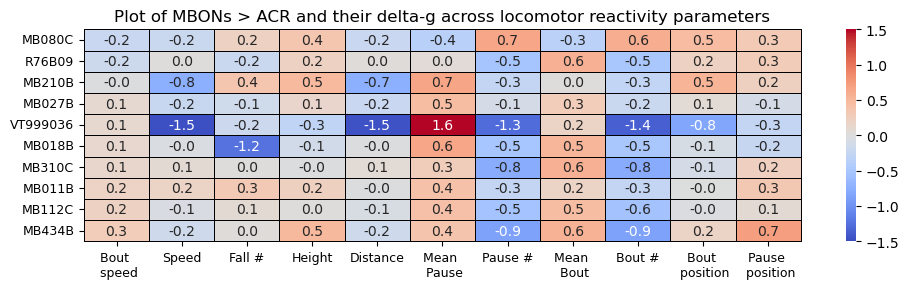

In [18]:
# f1,ax = plt.subplots(nrows=1, ncols=9, sharex=False, sharey = True, figsize=(15, 6))

df5 = dfreg2.set_index(['MBON'])

fig, ax1 = plt.subplots(figsize=(10, 3))                
g1 = sns.heatmap(df5, annot=True, fmt=".1f", vmin = -1.5, vmax = 1.5, cmap='coolwarm', linewidths=0.5, linecolor='black', clip_on=False)
g1.set_ylabel('')
g1.set_yticklabels(g1.get_yticklabels(), rotation = 0, fontsize = 9)
g1.set_xticklabels(g1.get_xticklabels(), rotation = 0, fontsize = 9)
ax1.set_title('Plot of MBONs > ' + responder + ' and their delta-g across locomotor reactivity parameters')
fig.tight_layout()
#plt.savefig(savelocation + "deltagheatmap_" + responder + "_" + date + ".png", dpi = 1200)


# regression map

Text(0.5, 1.0, 'R2 values')

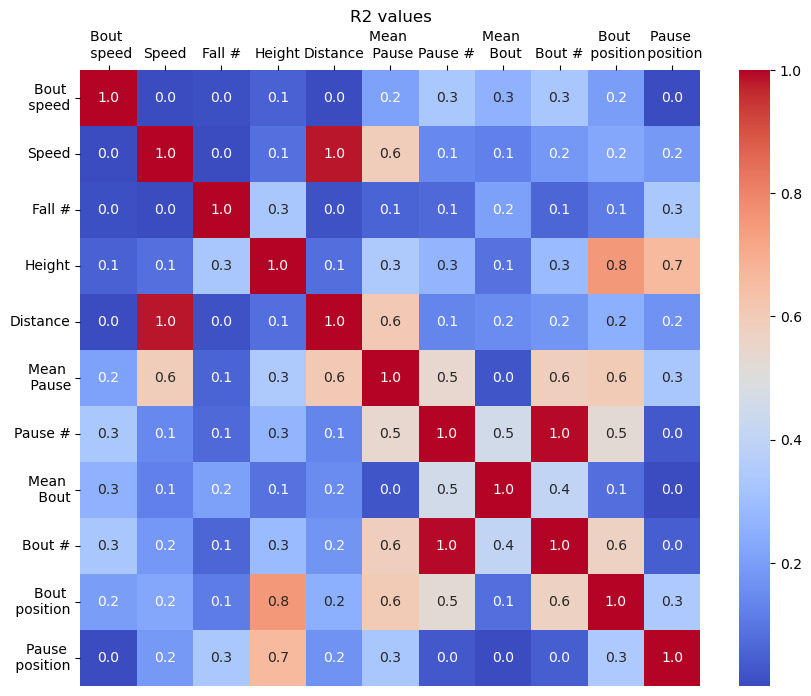

In [23]:
fig2, ax2 = plt.subplots(figsize=(10,8))  

mapp2 = sns.heatmap(dfr2, fmt=".1f", cmap = 'coolwarm', annot=True)
ax2.xaxis.tick_top()
ax2.set_title("R2 values")

#plt.savefig(savelocation + "regressionheatmap_" + responder + "_" + date + ".png")

In [ ]:
f, ax = plt.subplots(nrows=8, ncols=8,figsize=(25,20), sharey = True)  #ACR

subtypelst = dfreg2.columns[:-1].tolist()

for n, row in zip(subtypelst,[0,1,2,3,4,5,6,7]):
    for name, col in zip(subtypelst, [0]+[1]+[2]+[3]+[4]+[5]+[6]+[7]): #ACR

        ax[row][col].set_ylim(-2.1,2.1)  
        ax[row][col].set_xlim(-2.1,2.1) 
        ax[row][col].tick_params(axis='x', labelsize= 12)
        ax[row][col].tick_params(axis='y', labelsize= 12)
        
        ax[row][col].scatter(dfreg2[n], 
                    dfreg2[name],
                    color='red',
                    alpha=0.5,
                    s=20)
                   
        sns.regplot(x = dfreg2[n], y = dfreg2[name],
                scatter=False,
                line_kws={'lw':1}, 
                color="k",
                ax=ax[row][col],
                truncate=False)
        ax[row][col].set_ylabel(" ")
        ax[row][col].set_xlabel(name, fontsize=12)
    ax[row][0].set_ylabel(n, fontsize=12, rotation = 90)

    
#plt.savefig(savelocation + "regressioncompiled_" + responder + "_" + date + ".png")